## XGBoost
- 평가 Metric인 SMAPE는 실제값보다 작게 추정할 때 더 좋지 않음
  - 이는 전력사용량을 높게 예측하는 것보다 작게 예측할 때 실제로 더 큰 문제가 될 수 있음을 반영한 것으로 보임

- MSE를 objective function으로 훈련할 때 과소추정하는 건물이 있음을 확인
  - 따라서 objective function을 새로 정의함(weighted_mse)
  - 새 목적함수는 residual이 0보다 클 때, 즉 실제값보다 낮게 추정할 때 alpha만큼의 가중치를 곱해 반영함
  - XGBoost를 custom objective function으로 훈련하기 위해서는 gradient(1차 미분함수) / hessian(2차 미분함수)를 정의해 두 값을 return해줘야 함

- 모델 내 hyperparameter들은 sklearn의 gridsearchCV를 활용해 튜닝

- XGBoost의 early stopping 기능으로 n_estimator를 튜닝

- 이후 weighted_mse의 alpha 값을 튜닝

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 18.5 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor

pd.set_option('display.max_columns', 30)

In [5]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/XGBoost/data/train_preprocessed.csv")

# hour열 삭제, rain 결측치 0으로 채우기
train = train.drop("hour", axis = 1)
train["rain"] = train["rain"].fillna(0)
train.head()

,num,date_time,temp,rain,wind,hum,power,day,month,week,day_hour_mean,hour_mean,hour_std,day_mean,day_std,holiday,sin_time,cos_time,THI,sensory_temp,CDH
0,1,20220601 00,18.6,0.0,0.9,42.0,1085.28,2,6,22,1774.744615,1706.318118,446.882767,2682.796923,1136.240307,0,0.000000,1.000000,49.6576,20.751584,-7.4
1,1,20220601 01,18.0,0.0,1.1,45.0,1047.36,2,6,22,1687.347692,1622.620235,439.662704,2682.796923,1136.240307,0,0.258819,0.965926,47.7625,20.008954,-15.4
2,1,20220601 02,17.7,0.0,1.5,45.0,974.88,2,6,22,1571.483077,1506.971294,412.071906,2682.796923,1136.240307,0,0.500000,0.866025,47.2225,19.476910,-23.7
3,1,20220601 03,16.7,0.0,1.4,48.0,953.76,2,6,22,1522.153846,1437.365647,391.205981,2682.796923,1136.240307,0,0.707107,0.707107,44.7856,18.487958,-33.0
4,1,20220601 04,18.4,0.0,2.8,43.0,986.40,2,6,22,1506.793846,1447.321412,381.099697,2682.796923,1136.240307,0,0.866025,0.500000,49.0061,19.751534,-40.6


In [6]:
# Define SMAPE loss function
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) * 100

# XGBoost에서 모델 scoring 지표로 smape를 사용하기 위함
from sklearn.metrics import make_scorer
smape_scorer = make_scorer(SMAPE, greater_is_better=False)

In [7]:
# alpha를 argument로 받는 함수로 실제 objective function을 wrapping하여 alpha값을 쉽게 조정할 수 있도록 작성
# custom objective function for forcing model not to underestimate
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [8]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
df = pd.DataFrame(columns = ['n_estimators', 'eta', 'min_child_weight','max_depth', 'colsample_bytree', 'subsample'])
preds = np.array([])

grid = {'n_estimators' : [100], 'eta' : [0.01], 'min_child_weight' : np.arange(1, 8, 1),
        'max_depth' : np.arange(3,9,1) , 'colsample_bytree' :np.arange(0.8, 1.0, 0.1),
        'subsample' :np.arange(0.8, 1.0, 0.1)}

for i in tqdm(np.arange(1, 101)):
    y = train.loc[train.num == i, 'power']
    x = train.loc[train.num == i].drop(["num", "date_time", "power"], axis = 1)
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)


    pds = PredefinedSplit(np.append(-np.ones(len(x_train)-168), np.zeros(168)))
    gcv = GridSearchCV(estimator = XGBRegressor(seed=0),
                        param_grid = grid, scoring = smape_scorer, cv = pds, n_jobs = -1,refit = True, verbose = True)


    gcv.fit(x_train, y_train)
    best = gcv.best_estimator_
    params = gcv.best_params_
    print(params)
    pred = best.predict(x_valid)
    building = 'building'+str(i)
    print(building + '|| SMAPE : {}'.format(SMAPE(y_valid, pred)))
    preds = np.append(preds, pred)
    df = pd.concat([df, pd.DataFrame(params, index = [0])], axis = 0)
    df.to_csv('/content/drive/MyDrive/Colab Notebooks/XGBoost/data/hyperparameter_xgb.csv', index = False) # save the tuned parameters

  0%|          | 0/100 [00:00<?, ?it/s]

Fitting 1 folds for each of 168 candidates, totalling 168 fits
{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
building1|| SMAPE : 6.175834111564827


  1%|          | 1/100 [00:43<1:11:42, 43.46s/it]

Fitting 1 folds for each of 168 candidates, totalling 168 fits


  2%|▏         | 2/100 [01:07<52:17, 32.02s/it]  

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building2|| SMAPE : 5.363451059534376
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  3%|▎         | 3/100 [01:35<49:00, 30.32s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building3|| SMAPE : 8.821550444836015
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  4%|▍         | 4/100 [01:59<44:30, 27.82s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
building4|| SMAPE : 5.806138348966445
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  5%|▌         | 5/100 [02:26<43:23, 27.41s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
building5|| SMAPE : 8.23621292763752
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  6%|▌         | 6/100 [02:49<40:24, 25.80s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building6|| SMAPE : 6.910746488092438
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  7%|▋         | 7/100 [03:16<40:56, 26.42s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building7|| SMAPE : 10.634235646060615
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  8%|▊         | 8/100 [03:41<39:31, 25.78s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building8|| SMAPE : 3.2283287563514653
Fitting 1 folds for each of 168 candidates, totalling 168 fits


  9%|▉         | 9/100 [04:07<39:18, 25.92s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building9|| SMAPE : 6.891748511871058
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 10%|█         | 10/100 [04:31<37:58, 25.31s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
building10|| SMAPE : 4.257385883961386
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 11%|█         | 11/100 [04:57<38:01, 25.64s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8}
building11|| SMAPE : 3.0711054517729437
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 12%|█▏        | 12/100 [05:22<37:02, 25.25s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building12|| SMAPE : 3.7703728708443753
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 13%|█▎        | 13/100 [05:48<36:58, 25.50s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building13|| SMAPE : 2.681718148178605
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 14%|█▍        | 14/100 [06:13<36:25, 25.42s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
building14|| SMAPE : 8.267413072866768
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 15%|█▌        | 15/100 [06:43<37:48, 26.69s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building15|| SMAPE : 2.5061450496599518
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 16%|█▌        | 16/100 [07:03<34:55, 24.95s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building16|| SMAPE : 7.698939338245389
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 17%|█▋        | 17/100 [07:28<34:28, 24.92s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building17|| SMAPE : 8.664853119579806
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 18%|█▊        | 18/100 [07:53<33:48, 24.74s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building18|| SMAPE : 5.896185604573593
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 19%|█▉        | 19/100 [08:19<34:01, 25.20s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building19|| SMAPE : 9.713040504779435
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 20%|██        | 20/100 [08:40<32:00, 24.00s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building20|| SMAPE : 11.941058059154942
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 21%|██        | 21/100 [09:03<31:00, 23.55s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8}
building21|| SMAPE : 7.278705290693262
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 22%|██▏       | 22/100 [09:29<31:37, 24.32s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building22|| SMAPE : 4.752039747462974
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 23%|██▎       | 23/100 [09:50<29:55, 23.32s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building23|| SMAPE : 3.915330723355074
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 24%|██▍       | 24/100 [10:16<30:31, 24.09s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building24|| SMAPE : 4.51519899398877
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 25%|██▌       | 25/100 [10:41<30:45, 24.61s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building25|| SMAPE : 5.488297908231565
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 26%|██▌       | 26/100 [11:08<31:14, 25.33s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building26|| SMAPE : 4.012832690335295
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 27%|██▋       | 27/100 [11:34<31:00, 25.49s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building27|| SMAPE : 2.589291223396962
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 28%|██▊       | 28/100 [12:00<30:30, 25.42s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building28|| SMAPE : 6.323270358341723
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 29%|██▉       | 29/100 [12:26<30:17, 25.60s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building29|| SMAPE : 5.604887857571258
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 30%|███       | 30/100 [12:53<30:30, 26.15s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building30|| SMAPE : 5.946948125123756
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 31%|███       | 31/100 [13:18<29:40, 25.81s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
building31|| SMAPE : 4.998097608632897
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 32%|███▏      | 32/100 [13:45<29:32, 26.07s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building32|| SMAPE : 0.3455361571575309
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 33%|███▎      | 33/100 [14:10<28:44, 25.73s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building33|| SMAPE : 0.25320775045557614
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 34%|███▍      | 34/100 [14:32<27:20, 24.85s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building34|| SMAPE : 0.5357448946541112
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 35%|███▌      | 35/100 [14:59<27:20, 25.23s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building35|| SMAPE : 0.3775959572574188
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 36%|███▌      | 36/100 [15:24<26:50, 25.16s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building36|| SMAPE : 0.3424066060742011
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 37%|███▋      | 37/100 [15:46<25:31, 24.31s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building37|| SMAPE : 13.827765850380228
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 38%|███▊      | 38/100 [16:06<23:46, 23.01s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building38|| SMAPE : 15.714113415032422
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 39%|███▉      | 39/100 [16:24<22:01, 21.67s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building39|| SMAPE : 15.143353493893155
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 40%|████      | 40/100 [16:44<20:58, 20.97s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building40|| SMAPE : 16.469453167543854
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 41%|████      | 41/100 [17:07<21:26, 21.80s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building41|| SMAPE : 12.19082679725424
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 42%|████▏     | 42/100 [17:27<20:29, 21.20s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building42|| SMAPE : 23.40634948067063
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 43%|████▎     | 43/100 [17:45<19:11, 20.20s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building43|| SMAPE : 21.229587765054735
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 44%|████▍     | 44/100 [18:04<18:22, 19.69s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building44|| SMAPE : 19.839327296703043
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 45%|████▌     | 45/100 [18:28<19:12, 20.95s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building45|| SMAPE : 2.5380749740604354
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 46%|████▌     | 46/100 [18:53<20:10, 22.41s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building46|| SMAPE : 4.23292104228043
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 47%|████▋     | 47/100 [19:17<20:01, 22.67s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building47|| SMAPE : 4.425115940618824
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 48%|████▊     | 48/100 [19:41<20:11, 23.29s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building48|| SMAPE : 3.5750275444672313
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 49%|████▉     | 49/100 [20:05<19:53, 23.41s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.9}
building49|| SMAPE : 2.4436472646564296
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 50%|█████     | 50/100 [20:29<19:33, 23.46s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building50|| SMAPE : 2.839064359885777
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 51%|█████     | 51/100 [20:54<19:30, 23.89s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8}
building51|| SMAPE : 3.3895461629306176
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 52%|█████▏    | 52/100 [21:16<18:46, 23.46s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building52|| SMAPE : 4.508328855806672
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 53%|█████▎    | 53/100 [21:42<18:55, 24.15s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building53|| SMAPE : 13.872137928199225
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 54%|█████▍    | 54/100 [22:05<18:14, 23.79s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building54|| SMAPE : 17.49825275801796
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 55%|█████▌    | 55/100 [22:28<17:37, 23.51s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building55|| SMAPE : 1.524346217822222
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 56%|█████▌    | 56/100 [22:53<17:34, 23.97s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building56|| SMAPE : 0.9108608218197879
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 57%|█████▋    | 57/100 [23:16<16:58, 23.68s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building57|| SMAPE : 9.512234048187322
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 58%|█████▊    | 58/100 [23:44<17:32, 25.06s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8}
building58|| SMAPE : 0.39086164191380784
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 59%|█████▉    | 59/100 [24:05<16:17, 23.84s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building59|| SMAPE : 13.847325195628043
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 60%|██████    | 60/100 [24:29<16:02, 24.07s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
building60|| SMAPE : 6.712951661173745
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 61%|██████    | 61/100 [24:55<16:00, 24.62s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building61|| SMAPE : 4.8666614428870245
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 62%|██████▏   | 62/100 [25:24<16:16, 25.69s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
building62|| SMAPE : 5.302481800090984
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 63%|██████▎   | 63/100 [25:48<15:40, 25.43s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building63|| SMAPE : 5.538380607643906
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 64%|██████▍   | 64/100 [26:16<15:35, 25.99s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building64|| SMAPE : 4.558607824869002
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 65%|██████▌   | 65/100 [26:40<14:51, 25.47s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building65|| SMAPE : 6.451812986748775
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 66%|██████▌   | 66/100 [27:06<14:36, 25.79s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building66|| SMAPE : 2.6637051742163655
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 67%|██████▋   | 67/100 [27:31<13:56, 25.35s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building67|| SMAPE : 5.190270020848428
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 68%|██████▊   | 68/100 [28:00<14:04, 26.39s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building68|| SMAPE : 4.727474788363758
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 69%|██████▉   | 69/100 [28:23<13:07, 25.41s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building69|| SMAPE : 4.175725698761467
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 70%|███████   | 70/100 [28:49<12:47, 25.59s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building70|| SMAPE : 6.195242016369982
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 71%|███████   | 71/100 [29:13<12:12, 25.25s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building71|| SMAPE : 3.113469414155953
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 72%|███████▏  | 72/100 [29:39<11:48, 25.30s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building72|| SMAPE : 3.0189403035623807
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 73%|███████▎  | 73/100 [30:03<11:14, 24.97s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building73|| SMAPE : 2.3568707482244924
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 74%|███████▍  | 74/100 [30:27<10:43, 24.75s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building74|| SMAPE : 7.194752609310311
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 75%|███████▌  | 75/100 [30:53<10:24, 24.98s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building75|| SMAPE : 3.8482960344333605
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 76%|███████▌  | 76/100 [31:20<10:16, 25.69s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building76|| SMAPE : 2.94533358812981
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 77%|███████▋  | 77/100 [31:42<09:25, 24.57s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8}
building77|| SMAPE : 5.340747079809768
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 78%|███████▊  | 78/100 [32:03<08:39, 23.60s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building78|| SMAPE : 7.2353773287091805
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 79%|███████▉  | 79/100 [32:29<08:29, 24.28s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
building79|| SMAPE : 4.798142321003642
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 80%|████████  | 80/100 [32:51<07:50, 23.53s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
building80|| SMAPE : 10.449116318371427
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 81%|████████  | 81/100 [33:11<07:09, 22.63s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building81|| SMAPE : 13.239714272262923
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 82%|████████▏ | 82/100 [33:37<07:04, 23.59s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building82|| SMAPE : 8.656139380006387
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 83%|████████▎ | 83/100 [33:58<06:27, 22.80s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building83|| SMAPE : 9.824468336173155
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 84%|████████▍ | 84/100 [34:21<06:07, 22.96s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8}
building84|| SMAPE : 7.47560486710647
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 85%|████████▌ | 85/100 [34:48<06:00, 24.05s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
building85|| SMAPE : 4.394409017197138
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 86%|████████▌ | 86/100 [35:10<05:28, 23.43s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building86|| SMAPE : 9.065363109892823
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 87%|████████▋ | 87/100 [35:40<05:28, 25.31s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.8}
building87|| SMAPE : 7.381290493199274
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 88%|████████▊ | 88/100 [36:01<04:48, 24.06s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building88|| SMAPE : 12.610665745592364
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 89%|████████▉ | 89/100 [36:25<04:23, 23.96s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building89|| SMAPE : 13.12341911259265
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 90%|█████████ | 90/100 [36:48<03:57, 23.71s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building90|| SMAPE : 14.490203264995566
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 91%|█████████ | 91/100 [37:08<03:25, 22.80s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building91|| SMAPE : 13.287762265577232
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 92%|█████████▏| 92/100 [37:31<03:02, 22.87s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.8}
building92|| SMAPE : 9.75044024960779
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 93%|█████████▎| 93/100 [37:56<02:43, 23.31s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
building93|| SMAPE : 5.3373518766275785
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 94%|█████████▍| 94/100 [38:23<02:26, 24.45s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building94|| SMAPE : 4.98592972065045
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 95%|█████████▌| 95/100 [38:49<02:04, 24.90s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.9}
building95|| SMAPE : 9.016557903429234
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 96%|█████████▌| 96/100 [39:16<01:41, 25.48s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building96|| SMAPE : 3.610593400360693
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 97%|█████████▋| 97/100 [39:40<01:15, 25.26s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
building97|| SMAPE : 5.974653022807376
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 98%|█████████▊| 98/100 [40:08<00:51, 25.96s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building98|| SMAPE : 11.519071607582221
Fitting 1 folds for each of 168 candidates, totalling 168 fits


 99%|█████████▉| 99/100 [40:32<00:25, 25.31s/it]

{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'subsample': 0.9}
building99|| SMAPE : 5.998959165023808
Fitting 1 folds for each of 168 candidates, totalling 168 fits


100%|██████████| 100/100 [40:59<00:00, 24.59s/it]

{'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.9}
building100|| SMAPE : 7.431575062029673


In [9]:
xgb_params = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/XGBoost/data/hyperparameter_xgb.csv')

scores = []   # smape 값을 저장할 list
best_it = []  # best interation을 저장할 list
for i in tqdm(range(100)):
    y = train.loc[train.num == i+1, 'power']
    x = train.loc[train.num == i+1, ].drop(["num", "date_time", "power"], axis = 1)
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)

    xgb_reg = XGBRegressor(n_estimators = 10000, eta = 0.01, min_child_weight = xgb_params.iloc[i, 2],
                           max_depth = xgb_params.iloc[i, 3], colsample_bytree = xgb_params.iloc[i, 4],
                           subsample = xgb_params.iloc[i, 5], seed=0)
    xgb_reg.set_params(**{'objective':weighted_mse(100)}) # alpha = 100으로 고정

    xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train),
                                            (x_valid, y_valid)], early_stopping_rounds=300, verbose=False)
    y_pred = xgb_reg.predict(x_valid)
    pred = pd.Series(y_pred)

    sm = SMAPE(y_valid, y_pred)
    scores.append(sm)
    best_it.append(xgb_reg.best_iteration)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
  1%|          | 1/100 [00:01<02:38,  1.60s/it]/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
  2%|▏         | 2/100 [00:02<02:14,  1.37s/it]/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
  3%|▎         | 3/100 [00:04<02:31,  1.56s/it]/usr/local/lib/python3.10/dist-packages/xgb

In [10]:
alpha_list = []
smape_list = []
for i in tqdm(range(100)):
    y = train.loc[train.num == i+1, 'power']
    x = train.loc[train.num == i+1, ].drop(["num", "date_time", "power"], axis = 1)
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)
    xgb = XGBRegressor(seed = 0,
                      n_estimators = best_it[i], eta = 0.01, min_child_weight = xgb_params.iloc[i, 2],
                      max_depth = xgb_params.iloc[i, 3], colsample_bytree = xgb_params.iloc[i, 4], subsample = xgb_params.iloc[i, 5])

    xgb.fit(x_train, y_train)
    pred0 = xgb.predict(x_valid)
    best_alpha = 0
    score0 = SMAPE(y_valid,pred0)

    for j in [1, 3, 5, 7, 10, 25, 50, 75, 100]:
        xgb = XGBRegressor(seed = 0,
                      n_estimators = best_it[i], eta = 0.01, min_child_weight = xgb_params.iloc[i, 2],
                      max_depth = xgb_params.iloc[i, 3], colsample_bytree = xgb_params.iloc[i, 4], subsample = xgb_params.iloc[i, 5])
        xgb.set_params(**{'objective' : weighted_mse(j)})

        xgb.fit(x_train, y_train)
        pred1 = xgb.predict(x_valid)
        score1 = SMAPE(y_valid, pred1)
        if score1 < score0:
            best_alpha = j
            score0 = score1

    alpha_list.append(best_alpha)
    smape_list.append(score0)
    print("building {} || best score : {} || alpha : {}".format(i+1, score0, best_alpha))

  1%|          | 1/100 [00:07<12:27,  7.55s/it]

building 1 || best score : 3.01345946747657 || alpha : 1


  2%|▏         | 2/100 [00:15<12:43,  7.79s/it]

building 2 || best score : 4.502151146055912 || alpha : 0


  3%|▎         | 3/100 [00:22<11:53,  7.35s/it]

building 3 || best score : 5.203344124851488 || alpha : 1


  4%|▍         | 4/100 [00:34<14:53,  9.31s/it]

building 4 || best score : 1.8341486038982755 || alpha : 1


  5%|▌         | 5/100 [00:45<15:30,  9.79s/it]

building 5 || best score : 2.9355593765939676 || alpha : 0


  6%|▌         | 6/100 [00:57<16:30, 10.54s/it]

building 6 || best score : 1.7187496109570828 || alpha : 100


  7%|▋         | 7/100 [01:06<15:33, 10.04s/it]

building 7 || best score : 4.010238064426277 || alpha : 10


  8%|▊         | 8/100 [01:18<16:34, 10.81s/it]

building 8 || best score : 2.623570189046754 || alpha : 0


  9%|▉         | 9/100 [01:30<16:53, 11.13s/it]

building 9 || best score : 1.159945871152244 || alpha : 50


 10%|█         | 10/100 [01:35<13:53,  9.26s/it]

building 10 || best score : 3.2849851749539893 || alpha : 1


 11%|█         | 11/100 [02:00<20:48, 14.03s/it]

building 11 || best score : 1.6209442070901279 || alpha : 75


 12%|█▏        | 12/100 [02:44<33:51, 23.08s/it]

building 12 || best score : 2.0735563774990573 || alpha : 10


 13%|█▎        | 13/100 [02:57<29:09, 20.11s/it]

building 13 || best score : 2.5238870610654076 || alpha : 100


 14%|█▍        | 14/100 [03:01<21:51, 15.24s/it]

building 14 || best score : 7.70068536296997 || alpha : 50


 15%|█▌        | 15/100 [03:12<19:41, 13.90s/it]

building 15 || best score : 1.422992502770269 || alpha : 100


 16%|█▌        | 16/100 [03:30<21:18, 15.22s/it]

building 16 || best score : 1.9712489671760554 || alpha : 1


 17%|█▋        | 17/100 [03:41<19:11, 13.87s/it]

building 17 || best score : 2.9711805618621474 || alpha : 10


 18%|█▊        | 18/100 [03:48<16:07, 11.79s/it]

building 18 || best score : 3.86275262389574 || alpha : 3


 19%|█▉        | 19/100 [04:11<20:41, 15.33s/it]

building 19 || best score : 4.052821702845195 || alpha : 100


 20%|██        | 20/100 [04:20<17:41, 13.27s/it]

building 20 || best score : 2.387418321327777 || alpha : 10


 21%|██        | 21/100 [04:30<16:10, 12.29s/it]

building 21 || best score : 3.400906839043182 || alpha : 75


 22%|██▏       | 22/100 [04:40<15:14, 11.72s/it]

building 22 || best score : 1.8972724269633903 || alpha : 10


 23%|██▎       | 23/100 [04:54<15:41, 12.22s/it]

building 23 || best score : 0.9297434368679232 || alpha : 100


 24%|██▍       | 24/100 [05:01<13:41, 10.82s/it]

building 24 || best score : 1.1625729023901257 || alpha : 100


 25%|██▌       | 25/100 [05:14<14:07, 11.30s/it]

building 25 || best score : 0.9978184283063524 || alpha : 50


 26%|██▌       | 26/100 [05:24<13:38, 11.06s/it]

building 26 || best score : 1.1245163699442544 || alpha : 10


 27%|██▋       | 27/100 [05:31<12:00,  9.87s/it]

building 27 || best score : 0.8624552059836149 || alpha : 100


 28%|██▊       | 28/100 [05:39<11:11,  9.33s/it]

building 28 || best score : 2.0322348702005697 || alpha : 25


 29%|██▉       | 29/100 [05:46<09:59,  8.44s/it]

building 29 || best score : 1.9676036024577563 || alpha : 100


 30%|███       | 30/100 [06:14<16:49, 14.42s/it]

building 30 || best score : 3.4510950452046845 || alpha : 75


 31%|███       | 31/100 [06:22<14:28, 12.59s/it]

building 31 || best score : 2.219750760031569 || alpha : 3


 32%|███▏      | 32/100 [06:52<20:14, 17.86s/it]

building 32 || best score : 0.2234303204689567 || alpha : 1


 33%|███▎      | 33/100 [07:32<27:20, 24.49s/it]

building 33 || best score : 0.13975295738368357 || alpha : 75


 34%|███▍      | 34/100 [08:07<30:07, 27.39s/it]

building 34 || best score : 0.2989357242435143 || alpha : 100


 35%|███▌      | 35/100 [08:42<32:24, 29.91s/it]

building 35 || best score : 0.22383298977421148 || alpha : 100


 36%|███▌      | 36/100 [09:03<28:57, 27.15s/it]

building 36 || best score : 0.19159227799962605 || alpha : 100


 37%|███▋      | 37/100 [09:10<22:02, 20.99s/it]

building 37 || best score : 1.7756789560253043 || alpha : 50


 38%|███▊      | 38/100 [09:32<22:08, 21.42s/it]

building 38 || best score : 2.141730143309844 || alpha : 0


 39%|███▉      | 39/100 [09:41<18:01, 17.74s/it]

building 39 || best score : 1.9464653412745299 || alpha : 10


 40%|████      | 40/100 [09:48<14:27, 14.46s/it]

building 40 || best score : 4.439375733462155 || alpha : 0


 41%|████      | 41/100 [09:58<12:59, 13.22s/it]

building 41 || best score : 1.9770122740940903 || alpha : 7


 42%|████▏     | 42/100 [10:07<11:24, 11.80s/it]

building 42 || best score : 8.132061903948888 || alpha : 100


 43%|████▎     | 43/100 [10:18<10:52, 11.45s/it]

building 43 || best score : 2.8384731076779572 || alpha : 1


 44%|████▍     | 44/100 [10:25<09:25, 10.10s/it]

building 44 || best score : 2.1628379868670327 || alpha : 1


 45%|████▌     | 45/100 [10:37<09:50, 10.74s/it]

building 45 || best score : 0.9870813045464624 || alpha : 75


 46%|████▌     | 46/100 [10:48<09:46, 10.87s/it]

building 46 || best score : 2.225368957125959 || alpha : 100


 47%|████▋     | 47/100 [10:57<09:08, 10.34s/it]

building 47 || best score : 2.237929963854981 || alpha : 3


 48%|████▊     | 48/100 [11:06<08:37,  9.95s/it]

building 48 || best score : 1.0157538833331068 || alpha : 100


 49%|████▉     | 49/100 [11:54<18:08, 21.35s/it]

building 49 || best score : 1.030271784448777 || alpha : 5


 50%|█████     | 50/100 [12:14<17:24, 20.88s/it]

building 50 || best score : 1.38499044289895 || alpha : 1


 51%|█████     | 51/100 [12:27<15:15, 18.69s/it]

building 51 || best score : 1.806381254124313 || alpha : 100


 52%|█████▏    | 52/100 [12:49<15:46, 19.71s/it]

building 52 || best score : 1.9103726967579553 || alpha : 7


 53%|█████▎    | 53/100 [13:07<14:55, 19.05s/it]

building 53 || best score : 6.991792748488598 || alpha : 75


 54%|█████▍    | 54/100 [13:26<14:39, 19.12s/it]

building 54 || best score : 13.924468495161188 || alpha : 50


 55%|█████▌    | 55/100 [13:36<12:18, 16.40s/it]

building 55 || best score : 0.7829445321910183 || alpha : 100


 56%|█████▌    | 56/100 [14:06<14:51, 20.27s/it]

building 56 || best score : 0.43799581813634386 || alpha : 25


 57%|█████▋    | 57/100 [14:14<11:57, 16.69s/it]

building 57 || best score : 2.2730555018308847 || alpha : 25


 58%|█████▊    | 58/100 [14:33<12:09, 17.37s/it]

building 58 || best score : 0.21094184694947898 || alpha : 0


 59%|█████▉    | 59/100 [14:41<10:01, 14.67s/it]

building 59 || best score : 2.579046003701088 || alpha : 7


 60%|██████    | 60/100 [14:47<07:56, 11.92s/it]

building 60 || best score : 2.6182958712937006 || alpha : 75


 61%|██████    | 61/100 [15:15<10:57, 16.87s/it]

building 61 || best score : 1.859124835869612 || alpha : 3


 62%|██████▏   | 62/100 [15:25<09:24, 14.85s/it]

building 62 || best score : 2.101912633660897 || alpha : 3


 63%|██████▎   | 63/100 [15:38<08:49, 14.31s/it]

building 63 || best score : 2.351615588092198 || alpha : 0


 64%|██████▍   | 64/100 [15:51<08:11, 13.66s/it]

building 64 || best score : 1.8992150127170062 || alpha : 1


 65%|██████▌   | 65/100 [16:01<07:23, 12.67s/it]

building 65 || best score : 3.578315002683812 || alpha : 50


 66%|██████▌   | 66/100 [16:27<09:24, 16.59s/it]

building 66 || best score : 1.6730564722787296 || alpha : 100


 67%|██████▋   | 67/100 [16:40<08:33, 15.57s/it]

building 67 || best score : 2.175691971855578 || alpha : 7


 68%|██████▊   | 68/100 [17:00<09:07, 17.09s/it]

building 68 || best score : 1.5736145217846158 || alpha : 1


 69%|██████▉   | 69/100 [17:10<07:37, 14.74s/it]

building 69 || best score : 1.3190483620746387 || alpha : 10


 70%|███████   | 70/100 [17:24<07:20, 14.68s/it]

building 70 || best score : 1.7703439469570024 || alpha : 100


 71%|███████   | 71/100 [17:33<06:15, 12.94s/it]

building 71 || best score : 1.7618600149907744 || alpha : 10


 72%|███████▏  | 72/100 [17:42<05:31, 11.83s/it]

building 72 || best score : 1.6607779512409708 || alpha : 100


 73%|███████▎  | 73/100 [17:57<05:38, 12.55s/it]

building 73 || best score : 1.7069347295403468 || alpha : 1


 74%|███████▍  | 74/100 [18:07<05:06, 11.78s/it]

building 74 || best score : 2.3526725950210867 || alpha : 7


 75%|███████▌  | 75/100 [18:35<07:00, 16.80s/it]

building 75 || best score : 2.020670464829398 || alpha : 75


 76%|███████▌  | 76/100 [18:54<06:54, 17.29s/it]

building 76 || best score : 2.64189388946839 || alpha : 100


 77%|███████▋  | 77/100 [19:04<05:53, 15.39s/it]

building 77 || best score : 1.3231298067784267 || alpha : 100


 78%|███████▊  | 78/100 [19:14<05:01, 13.69s/it]

building 78 || best score : 1.713890975888245 || alpha : 100


 79%|███████▉  | 79/100 [19:25<04:28, 12.79s/it]

building 79 || best score : 1.067192154663037 || alpha : 25


 80%|████████  | 80/100 [19:34<03:52, 11.64s/it]

building 80 || best score : 2.5362293346478264 || alpha : 100


 81%|████████  | 81/100 [19:41<03:12, 10.16s/it]

building 81 || best score : 1.5676989651601074 || alpha : 3


 82%|████████▏ | 82/100 [19:50<03:00, 10.02s/it]

building 82 || best score : 2.1085108182614847 || alpha : 10


 83%|████████▎ | 83/100 [19:55<02:25,  8.56s/it]

building 83 || best score : 2.7343734486361253 || alpha : 0


 84%|████████▍ | 84/100 [20:05<02:23,  8.96s/it]

building 84 || best score : 1.3733880389615367 || alpha : 50


 85%|████████▌ | 85/100 [20:19<02:37, 10.48s/it]

building 85 || best score : 1.498854018740609 || alpha : 10


 86%|████████▌ | 86/100 [20:31<02:32, 10.88s/it]

building 86 || best score : 2.409872502674279 || alpha : 100


 87%|████████▋ | 87/100 [20:39<02:09,  9.95s/it]

building 87 || best score : 4.277915794009555 || alpha : 100


 88%|████████▊ | 88/100 [20:47<01:52,  9.36s/it]

building 88 || best score : 4.361143788186735 || alpha : 100


 89%|████████▉ | 89/100 [20:54<01:35,  8.70s/it]

building 89 || best score : 2.400365462303924 || alpha : 100


 90%|█████████ | 90/100 [21:04<01:30,  9.02s/it]

building 90 || best score : 2.359399666981732 || alpha : 10


 91%|█████████ | 91/100 [21:16<01:29,  9.96s/it]

building 91 || best score : 5.951972849419547 || alpha : 100


 92%|█████████▏| 92/100 [21:22<01:11,  8.88s/it]

building 92 || best score : 2.6298167236714813 || alpha : 75


 93%|█████████▎| 93/100 [21:33<01:06,  9.47s/it]

building 93 || best score : 3.0712799491213536 || alpha : 0


 94%|█████████▍| 94/100 [22:32<02:25, 24.21s/it]

building 94 || best score : 3.142891837207466 || alpha : 50


 95%|█████████▌| 95/100 [22:35<01:30, 18.02s/it]

building 95 || best score : 6.716146424568958 || alpha : 1


 96%|█████████▌| 96/100 [22:57<01:16, 19.09s/it]

building 96 || best score : 1.457990396246147 || alpha : 1


 97%|█████████▋| 97/100 [23:28<01:07, 22.54s/it]

building 97 || best score : 2.513498268928521 || alpha : 1


 98%|█████████▊| 98/100 [23:33<00:34, 17.46s/it]

building 98 || best score : 6.270708217883427 || alpha : 1


 99%|█████████▉| 99/100 [23:44<00:15, 15.43s/it]

building 99 || best score : 1.4605499094722176 || alpha : 3


100%|██████████| 100/100 [24:14<00:00, 14.54s/it]

building 100 || best score : 2.6185995111381817 || alpha : 25


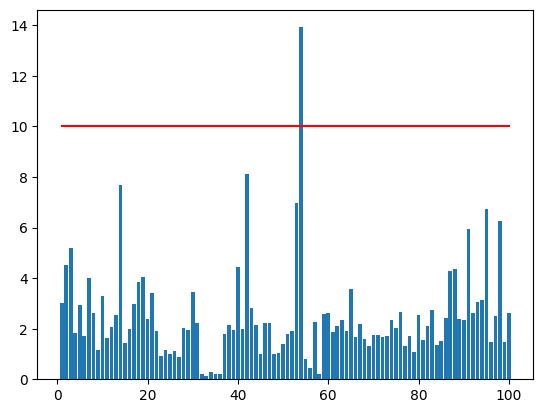

In [11]:
no_df = pd.DataFrame({'score':smape_list})
plt.bar(np.arange(len(no_df))+1, no_df['score'])
plt.plot([1,100], [10, 10], color = 'red')

In [12]:
xgb_params['alpha'] = alpha_list
xgb_params['best_it'] = best_it
xgb_params.head()

,n_estimators,eta,min_child_weight,max_depth,colsample_bytree,subsample,alpha,best_it
0,100,0.01,5,4,0.9,0.8,1,350
1,100,0.01,4,3,0.8,0.9,0,250
2,100,0.01,1,6,0.9,0.9,1,205
3,100,0.01,6,6,0.9,0.8,1,296
4,100,0.01,5,3,0.9,0.8,0,394


In [13]:
# 시각화
import warnings
warnings.filterwarnings("ignore")

for i in tqdm(range(100)):
    y = train.loc[train.num == i+1, 'power']
    x = train.loc[train.num == i+1, ].drop(["num", "date_time", "power"], axis = 1)
    y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168)
    xgb = XGBRegressor(seed = 0,
                      n_estimators = best_it[i], eta = 0.01, min_child_weight = xgb_params.iloc[i, 2],
                      max_depth = xgb_params.iloc[i, 3], colsample_bytree = xgb_params.iloc[i, 4], subsample = xgb_params.iloc[i, 5])
    xgb.set_params(**{'objective' : weighted_mse(xgb_params.iloc[i, 6])})
    xgb.fit(x_train, y_train)
    pred = xgb.predict(x_valid)
    pred = pd.Series(pred)
    pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
    plt.figure(figsize = (100, 1))
    plt.rc('font', family='NanumGothic')
    plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])
    plt.title(f"{i+1}번째 시설 시각화 결과")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [14]:
xgb_params.to_csv('/content/drive/MyDrive/Colab Notebooks/XGBoost/data/hyperparameter_xgb_final.csv', index=False)